In [1]:
import uproot
import sys
import glob
import os
import struct
import time
import csv
import pickle
import math
import gc
import pandas as pd
# import sympy
import numpy             as np
import matplotlib.pyplot as plt

#pyTorch libraries
import torch
from torch import nn

#Displaying images
from IPython.core.display import display, HTML, Image


import scipy
from   scipy             import interpolate
from   scipy.interpolate import CubicSpline, splev, splrep, interp1d, PPoly
from   scipy.optimize    import curve_fit, least_squares, minimize
from   scipy.signal      import find_peaks

import matplotlib             as mpl
import matplotlib.pyplot      as plt

#Plotting Config
mpl.style.use("default")
mpl.rcParams["axes.facecolor"] = "#EAEAF2" 
mpl.rcParams['figure.dpi']     = 100 
mpl.rcParams['savefig.dpi']    = 100 

#import jtplot
from jupyterthemes import jtplot
# you can select an alternative theme's plot style by name
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style('grade3')

C:\Users\musta\AppData\Local\Temp\ipykernel_8524\3950205441.py:21: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Image


# Basics 

## pyTorch source code

* PyTorch source code explanations:
    * https://jimmy-shen.medium.com/how-to-understand-pytorch-source-code-1fdbdbbf007e
    * https://github.com/pytorch/pytorch/blob/master/CONTRIBUTING.md#codebase-structure

## Tensors

###### Dimension of Tensors

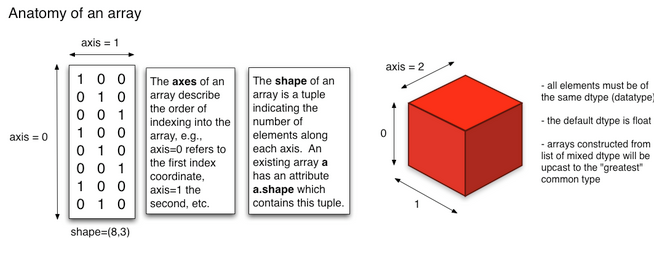

In [223]:
Image(filename="./figs/pytorch_tensor_dim.png")

In [ ]:
    |
    v
  dim-0  ---> -----> dim-1 ------> -----> -------->
    |   [[-1.7739,  0.8073,  0.0472, -0.4084],
    v    [ 0.6378,  0.6575, -1.2970, -0.0625],
    |    [ 1.7970, -1.3463,  0.9011, -0.8704],
    v    [ 1.5639,  0.7123,  0.0385,  1.8410]]
    |
    v

In [ ]:
# argmax (indices where max values are present) along dimension-1
In [215]: torch.argmax(a, dim=1)
Out[215]: tensor([1, 1, 0, 3])

# QuickStart

###### Input data

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

* PyTorch has two primitives to work with data: 
    * torch.utils.data.DataLoader
    * torch.utils.data.Dataset
    
* The image can be classified into 10 different classes: y=[0, ..., 10]
* Each image has 28x28 pixels

In [3]:
#Download training data
#    -transform=ToTensor() converts image data to tensors
training_data = datasets.FashionMNIST(root="datasets", train=True, download=True, 
                                      transform=ToTensor())

#Test data
test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

In [ ]:
#Load the data using DataLoader
#    -wraps an iterable over our dataset
#    -supports automatic batching, sampling, shuffling and multi-process data loading

#Each element in the dataloader iterable will return a batch of 64 training data and labels
batch_size = 64

#Data loaders
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader  = DataLoader(test_data, batch_size=batch_size)

for i, j in test_dataloader:
    print(f"Shape of i: [N, C, H, W]: {i.shape}")
    print(f"Shape of j: {j.shape} {j.dtype}")
    print("====================================")
    
    #Tensor shape of i
    #i = features: attributes of that event
    print("Tensor shape of i")
    print("len(i) = ", len(i))
    print(len(i[0]))
    print(len(i[0][0]))
    print(len(i[0][0][0]))
    print("====================================")

    #j = labels: truth values
    print("Tensor shape of j")
    print("len(j) = ", len(j))
    print(len(j))
    print("====================================")
    
    
    print("i = ", i)
    print("j = ", j)
    
    break

###### Build model

* We define our neural network by subclassing nn.Module, and initialize the neural network layers in __init__. 

* Every nn.Module subclass implements the operations on input data in the forward method.

* Hooks are functions that automatically execute after a particular event:
    * Website displays an ad after N different page visits: Phone dims the screen after N secs.
* In PyTorch, hooks are registered for each __Tensor__ or __nn.Module__ object are triggered by either `forward` or `backword` pass of the object
* Each hook can modify the input, output, or internal Module parameters.

In [ ]:
#Get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

In [6]:
#Create Models
#    - define the layers of the netwprk in __init__
#    - specify how data will pass through the network in the 'forward' function
class NeuralNetwork(nn.Module):
    
    def __init__(self):
        #type=NeuralNetwork, obj=self
        super(NeuralNetwork, self).__init__()
        
        #nn.Flatten layer to convert each 2D 28x28 image into a contiguous array of 784 pixel values
        #    -nn.Flatten() is creating an obj from the Flatten class
        #    -NeuralNetwork obj will have an Flatten obj as an attribute
        self.flatten = nn.Flatten()
        
        #Neural layers: Dense: 
        #    -Relu: rectified linear activation function: piecewise fn: f(x)=x for x positive.
        #    -nn.Linear(input feature dim, output feature dim)
        #    -first layer: 28*28 features -> 512
        #    -second layer:512 -> 512
        #    -third layer:512 -> 10
        #    -Again, Sequential is a class: The NeuralNetwork obj will have an attribute of obj from
        #     the Sequential class
        self.linear_relu_stack = nn.Sequential(nn.Linear(28*28, 512), nn.ReLU(), 
                                               nn.Linear(512, 512), nn.ReLU(),
                                               nn.Linear(512, 10))
    
    #Specify how data will pass through the network
    #     -This declaration of "forward" function is MANDATORY!!!
    def forward(self, x):
        
        #Flatten the data
        x = self.flatten(x)
        
        #build layers
        logits = self.linear_relu_stack(x)
        
        return logits

In [ ]:
#Build model
#    -to(device) sends model to cpu
#    -to() func declared in nn.Module class: returns self:
#    -returns a NeuralNetowkr object: model is a NeuralNetowrk obj that is also sent to "cpu"
model = NeuralNetwork().to(device)
print(model)

###### Optimize the Model Parameters: Loss fn & Optimizer

In [9]:
#Cross entrpy for loss fn
loss_fn = nn.CrossEntropyLoss()

#Stochastic gradient descent (SGD) optimizer
#    -lr: learning rate
#    -model.parameter(), format of input & output of layers are passed
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

###### Training + Testing

* To use the model, we pass it the input data. This executes the model’s forward, along with some background operations. 
    * In module.py, you will see that forward function is defined like the usual __call__ funciton.
    * __call__ : Callable[..., Any] = _call_impl in module.py
* Do not call model.forward() directly!
* Calling the model on the input returns a 10-dimensional tensor with raw predicted values for each class. We get the prediction probabilities by passing it through an instance of the nn.Softmax module.

In [11]:
#Train func
#    -In a single training loop, the models makes predictions on the training dataset (fed in batches)
#    -Then, backpropagates - the prediction error to adjust the model's parameter
#    -Backpropagation is repeated until a desired loss score is reached

def train(dataloader, model, loss_fn, optimizer):
    
    #Size of data
    size = len(dataloader.dataset)
    
    #Set the model in training mode (train func from module.py) 
    #    -NOT RECURSION
    model.train()
    
    #Train by batch
    #    -batch is the iterator here
    #    -X is the feature: attributes of each training data
    #    -y is the label: truth value
    #Flowchart of below training algorithms: IMPORTANT!
    #    -1. Feed the data into device
    #    -2. Make predictions based on the current model
    #    -3. Compute the loss score
    #    -4. Set the gradients to zero!!!
    #    -5. Compute the gradient again!!! (back-propagation)
    #    -6. Update/increment the weights: SGD
    for batch, (X, y) in enumerate(dataloader):
        
        #to(device) to send cpu
        #    -returns same objs: X and y
        #    -device="cpu": a string: to() function sends the features & labels to cpu
        #    -to() defined in module.py, but is used DataLoader obj....???????????????????????????????
        #    -X and y are TENSORS..........
        X, y = X.to(device), y.to(device)
        
        #Make prediction
        #    -Passing input data to the model executes the model's forward fn!
        #        -Under the hood, it is calling __call__ function which is redirected to the "forward" fn.
        #        -See torch/nn/module.py: __call__
        #        -It's like the __call__ function that is inheritted from parent class
        #    -Do not call model.forward() directly
        pred = model(X)
        
        #Compute prediction error
        #    -Shape is same as the targer: will have loss score for each input data
        #    -Output should be in tensor
        #    -In loss.py, class CrossEntropyLoss, the "forward" function is defined
        #        -"forward" is used as __call__ function: used when the object is called: obj(___).
        loss = loss_fn(pred, y)
        
        #Sets the gradients of all optimized :class:`torch.Tensor` s to zero.
        #    -Not setting the weights to zero: it's setting the gradients to zero
        optimizer.zero_grad()

        #backward() func on tensors
        #    -Defined in torch._tensor.py
        #    -Computes the gradient of current tensor w.r.t. graph leaves
        #        -tensor = phi_i as defined in my thesis: linear combination of previous layer nodes
        #        -graph leaves = weight
        #    -Graph is differentiated using the chain rule
        #        -This is the backpropagation: See Eq.73 in my dissertation
        loss.backward()
        
        #Updating the weight: SGF
        #    -w_new = w_old + learnRate*gradient
        optimizer.step()
        
        
        #Print scores
        #    -tensor.item(): returns the value of its tensor as a python number: only for scalar tensors
        #        -Defined in C++ library: torch/lib/libtorch_python
        if (batch%100 == 0):
            loss, current = loss.item(), batch*len(X)
            print(f"loss: {loss:>7f} \t [{current:>5d}/{size:>5d}]")

In [12]:
#Test func
def test(dataloader, model, loss_fn):
    
    #Declares
    size        = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    #Evaluate model
    #    -Sets the module in evaluation mode: Not train mode
    #    -self.train(False): calling train func in module.py and: set self.training = False
    model.eval()
    
    #torch.no_grad is a class
    #    -Disabling grad calc reduces memory consumption
    #    -__enter__
    #    -__exit__
    #torch.argmax(input, dim, keepdim=False)
    #    -Returns the indices of the maximum values of a tensor across a dimension.
    #    -Dimension is a very poor choice of wording here
    #        -Dim is pytorch actually means "axis"
    #        -dim=1: Row-wise
    #        -dim=0: Column-wise
    #    -(pred.argmax(1)==y)
    #        -test if the predicted (highest prob) choice equals the truth value
    #            -matching the indices
    #torch.Tensor.type()
    #    -Returns the type if `dtype` is not provided, else casts this object to the specified type.
    #torch.Tensor.sum()
    #    -Returns the sum as another tensor    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct   += (pred.argmax(1)==y).type(torch.float).sum().item()
            
#             print("===========================\n")
#             print("pred \n")
#             print(pred)
#             print("===========================\n")
#             print("pred.argmax(0)")
#             print(pred.argmax(0))
#             print("===========================\n")
#             print("pred.argmax(1)")
#             print(pred.argmax(1))
#             print("===========================\n")
#             print("pred.argmax(2)")
#             print(pred.argmax(2))
#             print("===========================\n")
#             print("y")
#             print(y)
#             print("===========================\n")
#             print("pred.argmax(1)==y")
#             print(pred.argmax(1)==y)
#             break
            
    test_loss /= num_batches
    correct   /= size
    
    print(f"Test Error: \n Accuracy: {100*correct:>0.1f}%, Avg loss: {test_loss:>8f}\n")

In [ ]:
#Execute Training and Testing
epochs = 5

for i in range(epochs):
    print(f"Epoch {i+1}\n----------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

###### Saving Models

* A common way to save a model is to serialize the internal state dictionary (containing the model parameters).

In [ ]:
torch.save(model.state_dict(), "./models/model.pth")
print("Saved PyTorch Model State to model.pth")

###### Loading Models

In [229]:
#Still need to create the model object
model = NeuralNetwork()

In [ ]:
#Loading model parameters via internal state dictionary
model.load_state_dict(torch.load("./models/model.pth"))

In [ ]:
#Using loaded model to make prediction
classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker",
            "Bag", "Ankle boot"]

#Make predictions
model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

# ETC